In [209]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import statistics
import matplotlib.pyplot as plt
import datetime
from difflib import SequenceMatcher
import random

In [5]:
with open('data/songkick/data_songkick_concerts.csv', encoding='utf-8') as file_concerts:
    concerts_df = pd.read_csv(file_concerts, index_col=0)
    
with open('data/songkick/data_songkick_venues.csv', encoding='utf-8') as file_venues:
    venues_df = pd.read_csv(file_venues, index_col=0)
    
with open('data/spotify/data_spotify_artists.csv', encoding='utf-8') as file_artists:
    artists_df = pd.read_csv(file_artists, index_col=0)

with open('data/spotify/data_spotify_top_genres_final.csv', encoding='utf-8') as file_genres:
    genres_df = pd.read_csv(file_genres, index_col=0)
    
with open('data/spotify/data_spotify_tracks.csv', encoding='utf-8') as file_tracks:
    tracks_df = pd.read_csv(file_tracks, index_col=0)

c:\users\cyrille\google drive\unil\ish\mémoire\thesis\env\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Remove wrong geo coordinates
A few geo coordinates of venues are way outside of Switzerland (songkick error)

In [49]:
# bounds of Switzerland: lat(45.81806, 47.80833), lon(5.956389, 10.49194)

# find venues that have at least one coordinate out of bounds of Switzerland
venues_outofbounds_df = venues_df.loc[venues_df['latitude'] < 45.81806]
venues_outofbounds_df = venues_outofbounds_df.append(venues_df.loc[venues_df['latitude'] > 47.80833])
venues_outofbounds_df = venues_outofbounds_df.append(venues_df.loc[venues_df['longitude'] < 5.956389])
venues_outofbounds_df = venues_outofbounds_df.append(venues_df.loc[venues_df['longitude'] > 10.49194])

# drop duplicate rows (i.e. venues with both lat and lon out of bounds)
venues_outofbounds_df = venues_outofbounds_df[~venues_outofbounds_df.index.duplicated(keep='first')]
venues_outofbounds_df

,venue,locality,postal_code,street,country,latitude,longitude,venue_website
/venues/3358309,Gloria Theater Säckingen,Winterthur,79713,Friedrichstrasse 21,Switzerland,32.50171,-101.77517,NaN
/venues/3369229,Geneva Lake Festival,Geneva,1200,NaN,Switzerland,38.85429,-85.03181,NaN
/venues/3947699,Giovani per l'Africa,Locarno,6654,Via al Lambic,Switzerland,45.75275,10.73193,NaN
/venues/86894,Stadthalle Chur,Chur,7000,Weststrasse 5,Switzerland,52.34042,-8.86207,NaN
/venues/4019069,Forum Royal,Baden,4058,Schwarzwald Allee 175,Switzerland,48.27749,8.18600,NaN
/venues/2603448,Porrentruy-Delle Jazz Festival,Porrentruy,NaN,Place du Pré de l'étang,Switzerland,46.26427,-0.01434,NaN


In [51]:
# remove coordinates
venues_outofbounds_df[['latitude', 'longitude']] = ''

venues_outofbounds_df.to_csv('data/songkick/data_songkick_venues_outofbounds.csv', encoding='utf-8')
venues_outofbounds_df

,venue,locality,postal_code,street,country,latitude,longitude,venue_website
/venues/3358309,Gloria Theater Säckingen,Winterthur,79713,Friedrichstrasse 21,Switzerland,,,NaN
/venues/3369229,Geneva Lake Festival,Geneva,1200,NaN,Switzerland,,,NaN
/venues/3947699,Giovani per l'Africa,Locarno,6654,Via al Lambic,Switzerland,,,NaN
/venues/86894,Stadthalle Chur,Chur,7000,Weststrasse 5,Switzerland,,,NaN
/venues/4019069,Forum Royal,Baden,4058,Schwarzwald Allee 175,Switzerland,,,NaN
/venues/2603448,Porrentruy-Delle Jazz Festival,Porrentruy,NaN,Place du Pré de l'étang,Switzerland,,,NaN


## Find duplicate venues

In [21]:
# find venues that have same latitude-longitude coordinates

duplicate_coord = venues_df[venues_df.duplicated(subset=['latitude', 'longitude'], keep=False)]
duplicate_coord = duplicate_coord.sort_values(by=['latitude', 'longitude']).dropna(subset=['latitude', 'longitude'])
duplicate_coord.to_csv('data/songkick/data_songkick_venues_duplicates_coord.csv', encoding='utf-8')
duplicate_coord

,venue,locality,postal_code,street,country,latitude,longitude,venue_website
/venues/2206528,Gwenstival,Chiasso,NaN,NaN,Switzerland,45.83493,9.02702,NaN
/venues/2748968,Jazz in Bess,Chiasso,NaN,NaN,Switzerland,45.83493,9.02702,NaN
/venues/2955063,"Sala Teatro, LAC",Lugano,6900,Piazza Bernardino Luini 6,Switzerland,46.00006,8.94840,NaN
/venues/3391179,"Hall, LAC",Lugano,6900,Piazza Bernardino Luini 6,Switzerland,46.00006,8.94840,NaN
/venues/3340969,"Palco Teatro, LAC",Lugano,6900,Piazza Bernardino Luini 6,Switzerland,46.00006,8.94840,NaN
...,...,...,...,...,...,...,...,...
/venues/3707799,Pfarreizentrum St.Maria,Schaffhausen,NaN,NaN,Switzerland,47.69589,8.63805,NaN
/venues/3532824,Haberhaus Bühne,Schaffhausen,NaN,NaN,Switzerland,47.69589,8.63805,NaN
/venues/3656984,SVC Schaffhausen,Schaffhausen,NaN,NaN,Switzerland,47.69589,8.63805,NaN
/venues/2286379,Kammgarn/haberhaus/taptab,Schaffhausen,8200,NaN,Switzerland,47.71142,8.62654,NaN


In [61]:
# find venues that have same name

duplicate_name = venues_df[venues_df.duplicated(subset=['venue'], keep=False)]
# remove venues that have same geo coord since they have been treated above (but keeps rows with NaN as geo coord)
duplicate_name = duplicate_name[(~duplicate_name.duplicated(subset=['latitude', 'longitude'])) | (duplicate_name['latitude'].isnull())]
# keep only venues with duplicate name after removing venues with same geo coord
duplicate_name = duplicate_name[duplicate_name.duplicated(subset=['venue'], keep=False)]
# sort by venue name and drop rows where there is no venue name
duplicate_name = duplicate_name.sort_values(by=['venue', 'locality']).dropna(subset=['venue'])
duplicate_name.to_csv('data/songkick/data_songkick_venues_duplicates_name.csv', encoding='utf-8')
duplicate_name.iloc[:]

,venue,locality,postal_code,street,country,latitude,longitude,venue_website
/venues/2173104,3 Eidgenossen,Appenzell,9050,NaN,Switzerland,47.33493,9.40659,NaN
/venues/3286284,3 Eidgenossen,Bern,3011,Rathausgasse 69,Switzerland,46.94838,7.44850,NaN
/venues/1891153,A2,Basel,4334,test2strasse 4,Switzerland,NaN,NaN,NaN
/venues/1889048,A2,Zürich,NaN,ui zu 4,Switzerland,47.36740,8.53813,NaN
/venues/1596733,Aiglon,Geneva,NaN,NaN,Switzerland,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
/venues/4388045,YouTube Live,Schaffhausen,NaN,NaN,Switzerland,NaN,NaN,NaN
/venues/2089514,Zoo Club,Aarau,NaN,NaN,Switzerland,NaN,NaN,NaN
/venues/2109919,Zoo Club,Geneva,NaN,NaN,Switzerland,NaN,NaN,NaN
/venues/1317161,Zum Goldenen Fass,Basel,NaN,NaN,Switzerland,NaN,NaN,http://www.goldenes-fass.ch/%20-


In [64]:
# find venues that have same address

duplicate_address = venues_df[venues_df.duplicated(subset=['street'], keep=False)]
# remove venues that have same geo coord since they have been treated above (but keeps rows with NaN as geo coord)
duplicate_address = duplicate_address[(~duplicate_address.duplicated(subset=['latitude', 'longitude'])) | (duplicate_address['latitude'].isnull())]
# remove venues that have same name since they have been treated above (but keeps rows with NaN as name)
duplicate_address = duplicate_address[(~duplicate_address.duplicated(subset=['venue'])) | (duplicate_address['venue'].isnull())]
# keep only venues with duplicate street after removing venues with same geo coord and same name
duplicate_address = duplicate_address[duplicate_address.duplicated(subset=['street'], keep=False)]
# sort by venue name and drop rows where there is no venue name
duplicate_address = duplicate_address.sort_values(by=['street', 'venue']).dropna(subset=['street'])
duplicate_address.to_csv('data/songkick/data_songkick_venues_duplicates_address.csv', encoding='utf-8')
duplicate_address

,venue,locality,postal_code,street,country,latitude,longitude,venue_website
/venues/4419137,Jeunes Rives Neuchâtel,Neuchatel,2000,.,Switzerland,46.99960,6.93441,NaN
/venues/1760963,Tankstell Bar,St. Gallen,NaN,.,Switzerland,47.41793,9.36440,NaN
/venues/2111169,Brasseur des Grottes,Geneva,1201,2 Rue de la Servette,Switzerland,46.20978,6.13897,NaN
/venues/4233339,Uptown Geneva,Geneva,1201,2 Rue de la Servette,Switzerland,46.20951,6.13942,NaN
/venues/2940063,Dig It Records,Geneva,NaN,3 rue de la Servette,Switzerland,46.20893,6.13957,NaN
...,...,...,...,...,...,...,...,...
/venues/3217028,Theater an der Winkelwiese,Zürich,CH-8001 Zürich,Winkelwiese 4,Switzerland,47.37016,8.54671,http://winkelwiese.ch/
/venues/66426,Kongresshaus Biel,Biel,2502,Zentralstrasse 60,Switzerland,47.13488,7.24856,NaN
/venues/3118569,Palais des Congrès,Biel,2501,Zentralstrasse 60,Switzerland,47.13485,7.24780,http://www.ctsbiel-bienne.ch/
/venues/3977044,Gate54,Baden,5400,Zürcherstrasse 1,Switzerland,47.47113,8.30619,NaN


### Merge manual changes to venues data

In [188]:
with open('data/songkick/data_songkick_venues_duplicates_address_manual.csv', encoding='utf-8') as file:
    address_manual_df = pd.read_csv(file, index_col=0)
    # keep only rows where there is manual input
    address_manual_df = address_manual_df.loc[(pd.notna(address_manual_df['manual_input'])) & (address_manual_df['manual_input'] != 'X')]
    
with open('data/songkick/data_songkick_venues_duplicates_coord_manual.csv', encoding='utf-8') as file:
    coord_manual_df = pd.read_csv(file, index_col=0)
    # keep only rows where there is manual input
    coord_manual_df = coord_manual_df.loc[(pd.notna(coord_manual_df['manual_input'])) & (coord_manual_df['manual_input'] != 'X')]
    
with open('data/songkick/data_songkick_venues_duplicates_name_manual.csv', encoding='utf-8') as file:
    name_manual_df = pd.read_csv(file, index_col=0)
    # keep only rows where there is manual input
    name_manual_df = name_manual_df.loc[(pd.notna(name_manual_df['manual_input'])) & (name_manual_df['manual_input'] != 'X')]
    
with open('data/songkick/data_songkick_venues_no_duplicate_manual.csv', encoding='utf-8') as file:
    manual_changes_df = pd.read_csv(file, index_col=0)
    # keep only rows where there is manual input
    manual_changes_df = manual_changes_df.loc[(pd.notna(manual_changes_df['manual_input']))]
    manual_changes_df = manual_changes_df.drop(columns=['manual_input']).rename(columns={'linked_venue_id': 'manual_input'})
    
with open('data/songkick/data_songkick_venues_outofbounds.csv', encoding='utf-8') as file:
    out_of_bounds_df = pd.read_csv(file, index_col=0)

In [189]:
# nbr of venues manually edited

nbr_address_manual = len(address_manual_df)
nbr_coord_manual = len(coord_manual_df)
nbr_name_manual = len(name_manual_df)
nbr_manual_changes = len(manual_changes_df)
total_venues_edited = sum([nbr_address_manual, nbr_coord_manual, nbr_manual_changes, nbr_name_manual])

print('Venues with same address edited:', nbr_address_manual)
print('Venues with same coordinates edited:', nbr_coord_manual)
print('Venues with same name edited:', nbr_name_manual)
print('Venues manually edited:', nbr_manual_changes)
print('Total venues edited:', total_venues_edited)
print('-----')
print('Venues with out of bounds coordinates:', len(out_of_bounds_df))

Venues with same address edited: 104
Venues with same coordinates edited: 271
Venues with same name edited: 60
Venues manually edited: 21
Total venues edited: 456
-----
Venues with out of bounds coordinates: 6


In [190]:
# add column 'linked_venue_id' by copying the index

venues_no_duplicate_df = venues_df.copy()
venues_no_duplicate_df['linked_venue_id'] = venues_no_duplicate_df.index
venues_no_duplicate_df

,venue,locality,postal_code,street,country,latitude,longitude,venue_website,linked_venue_id
/venues/1943879,"Sargans, Switzerland",Mels,8887,NaN,Switzerland,47.04380,9.42400,NaN,/venues/1943879
/venues/2958443,"Kiental, Switzerland",Frutigen,3723,NaN,Switzerland,46.54310,7.75573,http://naturalsound.ch,/venues/2958443
/venues/78549,"Wetzikon, Switzerland",Wetzikon,NaN,NaN,Switzerland,47.32706,8.80136,NaN,/venues/78549
/venues/29550,Hallenstadion,Zürich,8050,Wallisellenstrasse 45,Switzerland,47.41161,8.55166,http://www.hallenstadion.ch/,/venues/29550
/venues/32239,Hive,Zürich,8005,Geroldstrasse 5,Switzerland,47.38537,8.52047,http://www.hiveclub.ch/,/venues/32239
...,...,...,...,...,...,...,...,...,...
/venues/2763668,House Show,Biel,NaN,NaN,Switzerland,47.14019,7.24377,NaN,/venues/2763668
/venues/4402932,YouTube Live,Geneva,NaN,NaN,Switzerland,NaN,NaN,NaN,/venues/4402932
/venues/3754699,Mcgees Irish Pub,Zürich,8003,Birmensdorferstrasse 83,Switzerland,47.37078,8.52391,NaN,/venues/3754699
/venues/4420939,Freie Evangelische Gemeinde Emmen,Luzern,6032,Mooshüslistrasse 32,Switzerland,47.07869,8.29039,http://www.feg-emmen.ch,/venues/4420939


In [191]:
# remove latitude and longitude from out of bounds venues

for idx, row in out_of_bounds_df.iterrows():
    venues_no_duplicate_df.loc[idx, 'latitude'] = ''
    venues_no_duplicate_df.loc[idx, 'longitude'] = ''

venues_no_duplicate_df.loc[out_of_bounds_df.index]

,venue,locality,postal_code,street,country,latitude,longitude,venue_website,linked_venue_id
/venues/3358309,Gloria Theater Säckingen,Winterthur,79713,Friedrichstrasse 21,Switzerland,,,NaN,/venues/3358309
/venues/3369229,Geneva Lake Festival,Geneva,1200,NaN,Switzerland,,,NaN,/venues/3369229
/venues/3947699,Giovani per l'Africa,Locarno,6654,Via al Lambic,Switzerland,,,NaN,/venues/3947699
/venues/86894,Stadthalle Chur,Chur,7000,Weststrasse 5,Switzerland,,,NaN,/venues/86894
/venues/4019069,Forum Royal,Baden,4058,Schwarzwald Allee 175,Switzerland,,,NaN,/venues/4019069
/venues/2603448,Porrentruy-Delle Jazz Festival,Porrentruy,NaN,Place du Pré de l'étang,Switzerland,,,NaN,/venues/2603448


In [192]:
# get the index of rows found in both address_df and coord_df
index_duplicates = coord_manual_df.merge(address_manual_df['manual_input'], how='inner', left_index=True, right_index=True).index
# remove rows in address_df found as well in coord_df
address_manual_df = address_manual_df.drop(index_duplicates)

# append address_df, coord_df and name_df together
duplicate_venues_df = address_manual_df.append(coord_manual_df)
duplicate_venues_df = duplicate_venues_df.append(name_manual_df)
duplicate_venues_df = duplicate_venues_df.append(manual_changes_df)

# if a venue appears twice (it has been assigned a linked venue in another manual_df), remove the first occurrence(s)
# the last occurrence is the manual change, so more reliable
duplicate_venues_df = duplicate_venues_df.loc[~duplicate_venues_df.index.duplicated(keep='last')]

# check if venue names match (dev only)
#duplicate_venues_df = duplicate_venues_df.merge(venues_df['venue'], left_on='manual_input', right_index=True)
duplicate_venues_df.sort_values(by='venue')

,venue,locality,postal_code,street,country,latitude,longitude,venue_website,manual_input
/venues/4044449,2m2c Montreux Music & Convention Center,Montreux,1820,Avenue Claude Nobs 5,Switzerland,46.43922,6.90435,NaN,/venues/3958664
/venues/4196689,40è Jura,Biel,2350,Marché-Concours 14,Switzerland,47.25454,6.99807,https://www.jura.ch/fr/Autorites/40e-anniversa...,/venues/4221109
/venues/3637199,43. Winterthurer Musikfestwochen,Winterthur,8400,Steinberggasse,Switzerland,47.49831,8.72831,http://www.musikfestwochen.ch/,/venues/505121
/venues/4237939,8x15 (Arcas Rock),Chur,7000,Arcas,Switzerland,46.84795,9.53171,https://www.srf.ch/play/tv/sendung/8x15-?id=c5...,/venues/4315914
/venues/3892314,A la Pointe,Geneva,1205,Sentier des Saules 27,Switzerland,46.20140,6.12323,NaN,/venues/2747113
...,...,...,...,...,...,...,...,...,...
/venues/2109919,Zoo Club,Geneva,NaN,NaN,Switzerland,NaN,NaN,NaN,/venues/32891
/venues/3194099,le signe,Biel,2502,Untergasse 21,Switzerland,47.14170,7.24703,http://www.lesinge.ch,/venues/2929128
/venues/3958534,lethargy,Zürich,8038 Zurich,Seestrasse 395,Switzerland,47.34356,8.53583,http://www.lethargy.ch/2018/,/venues/30935
/venues/4210229,lit.z Literaturhaus Zentralschweiz,Stans,6370,Alter Postplatz 3,Switzerland,46.95788,8.36525,NaN,/venues/896376


In [194]:
# check that there is no duplicate venue_id

duplicate_venues_df.loc[duplicate_venues_df.index.duplicated(keep=False)]

,venue,locality,postal_code,street,country,latitude,longitude,venue_website,manual_input


In [197]:
# for each duplicate venue, set the linked_venue_id to the venue_id found in manual_input
count = 0
for idx, row in duplicate_venues_df.iterrows():
    linked_venue_id = row['manual_input']
    if idx == linked_venue_id:
        print(row)
    venues_no_duplicate_df.loc[idx, 'linked_venue_id'] = linked_venue_id

venues_no_duplicate_df.to_csv('data/songkick/data_songkick_venues_no_duplicate.csv', encoding='utf-8')
venues_no_duplicate_df

,venue,locality,postal_code,street,country,latitude,longitude,venue_website,linked_venue_id
/venues/1943879,"Sargans, Switzerland",Mels,8887,NaN,Switzerland,47.0438,9.424,NaN,/venues/1943879
/venues/2958443,"Kiental, Switzerland",Frutigen,3723,NaN,Switzerland,46.5431,7.75573,http://naturalsound.ch,/venues/2958443
/venues/78549,"Wetzikon, Switzerland",Wetzikon,NaN,NaN,Switzerland,47.3271,8.80136,NaN,/venues/78549
/venues/29550,Hallenstadion,Zürich,8050,Wallisellenstrasse 45,Switzerland,47.4116,8.55166,http://www.hallenstadion.ch/,/venues/29550
/venues/32239,Hive,Zürich,8005,Geroldstrasse 5,Switzerland,47.3854,8.52047,http://www.hiveclub.ch/,/venues/32239
...,...,...,...,...,...,...,...,...,...
/venues/2763668,House Show,Biel,NaN,NaN,Switzerland,47.1402,7.24377,NaN,/venues/2763668
/venues/4402932,YouTube Live,Geneva,NaN,NaN,Switzerland,NaN,NaN,NaN,/venues/4402932
/venues/3754699,Mcgees Irish Pub,Zürich,8003,Birmensdorferstrasse 83,Switzerland,47.3708,8.52391,NaN,/venues/3754699
/venues/4420939,Freie Evangelische Gemeinde Emmen,Luzern,6032,Mooshüslistrasse 32,Switzerland,47.0787,8.29039,http://www.feg-emmen.ch,/venues/4420939


## Find duplicate artists
---

In [210]:
with open('data/spotify/data_spotify_artists.csv', encoding='utf-8') as file:
    spotify_artists_df = pd.read_csv(file, index_col=0)
    
spotify_artists_df

,artist_name,spotify_name,spotify_id,spotify_similarity,spotify_popularity,spotify_followers,spotify_listeners,spotify_genre_1,spotify_genre_2,spotify_genre_3,...,spotify_genre_9,spotify_genre_10,spotify_genre_11,spotify_genre_12,spotify_genre_13,spotify_genre_14,spotify_genre_15,spotify_genre_16,spotify_genre_17,spotify_genre_18
/artists/3684861-chk-chk-chk,!!! (Chk Chk Chk),!!!,1mmehjf7eHA10uHMisZGJg,0.30,47.0,135100.0,305800.0,alternative dance,dance rock,dance-punk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/artists/694091-kadebostan,!!!Kadebostan!!!,Kadebostan,6hWRK8VkzbYP9p17M5APJR,0.77,11.0,1348.0,2000.0,swiss techno,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/artists/5929284-brothers-in-bamako,"""Brothers In Bamako""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/artists/8704378-floyd-division-the-austrian-pink-floyd-tribute-band,"""Floyd Division"" The Austrian Pink Floyd Tribu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/artists/7172094-jazzetcetera-stewy-von-wattenwyl-group-feat-lisette-spinnler,"""Jazz...etcetera"" Stewy von Wattenwyl Group, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/artists/4301-and-you-will-know-us-by-the-trail-of-dead,…And You Will Know Us by the Trail of Dead,...And You Will Know Us by the Trail of Dead,6wBUn8gMP85n8dPu6LoUcF,0.95,41.0,64802.0,99200.0,alternative rock,double drumming,indie rock,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/artists/1099500-euuroshima,€urOshima,Taro Urashima,5RSxs4Rb82wINvjv5KJ7JK,0.64,36.0,14600.0,79300.0,okinawan pop,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/artists/9573874-belize-it,≈ Belize ≈,≈ Belize ≈,3b8bBMsmGoBd8gYn1pngNc,1.00,18.0,6697.0,4900.0,italian indie pop,milan indie,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/artists/8889739-luo-chai-cao-yuan-wwww-prairie-wwww,落差草原 WWWW / Prairie WWWW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [274]:
spotify_duplicates_df = spotify_artists_df.copy()
print(len(spotify_duplicates_df))

# remove artists without spotify match
spotify_duplicates_df = spotify_duplicates_df.dropna(subset=['spotify_id'])
print(len(spotify_duplicates_df))

# sort artists by their spotify_id and spotify_similarity
spotify_duplicates_df = spotify_duplicates_df.sort_values(by=['spotify_id', 'spotify_similarity'], ascending=[True, False])

# get the artists with same spotify_id (different songkick artists linked to same spotify artist)
spotify_duplicates_df = spotify_duplicates_df.loc[spotify_duplicates_df.duplicated(['spotify_id'], keep=False)]
print(len(spotify_duplicates_df))

# for each spotify_id duplicate, keep the artist with highest spotify_similarity
spotify_duplicates_df = spotify_duplicates_df.drop_duplicates(['spotify_id'], keep='last')
print(len(spotify_duplicates_df))

spotify_duplicates_df

32231
28572
913
448


,artist_name,spotify_name,spotify_id,spotify_similarity,spotify_popularity,spotify_followers,spotify_listeners,spotify_genre_1,spotify_genre_2,spotify_genre_3,...,spotify_genre_10,spotify_genre_11,spotify_genre_12,spotify_genre_13,spotify_genre_14,spotify_genre_15,spotify_genre_16,spotify_genre_17,spotify_genre_18,artist_id
/artists/10113663-kappeli,Käppeli,Marco Käppeli,01PFotUdgpp0lu0zrmKCaF,0.70,0.0,12.0,40.0,jazz drums,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/10113663-kappeli
/artists/9749499-wankel-mut,Wankel mut,Wankelmut,01e2lCvLZ4fLUIRy68nptH,0.95,61.0,105892.0,2200000.0,deep euro house,tropical house,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/9749499-wankel-mut
/artists/9166249-tweek-ch,Tweek,Tweek,02vhOXy4CjMpUBjYSZL16K,1.00,1.0,10.0,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/9166249-tweek-ch
/artists/1598119-deep-kick,Deep Kick,Deep Kick,04Hs55zsxm09wzTYIkU5hp,1.00,10.0,1925.0,1200.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/1598119-deep-kick
/artists/7385784-fola-dada-d,Fola Dada [d],Fola Dada,04wxbNa2kRKOpAWvfzC4cH,0.82,12.0,533.0,796.0,stuttgart indie,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/7385784-fola-dada-d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/artists/3620371-manillo,Manillo,Manillio,7uxtLjuqkJ3cnjQQuW6Cul,0.93,38.0,16134.0,42000.0,mundart,schweizer rap,swiss hip hop,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/3620371-manillo
/artists/9314729-prader-und-knecht,Prader und Knecht,Prader & knecht,7vPfT2ODlMR2mGPyQ8YLMZ,0.88,1.0,187.0,57.0,swiss rock,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/9314729-prader-und-knecht
/artists/10072470-clark-s,Clark S.,CLARK S,7wVuJ6vmRdHikgyDTEVNDs,0.93,6.0,265.0,519.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/10072470-clark-s
/artists/9772294-oceans-ger,Oceans,Oceans,7x3hXpGkI296eBLTbhbND0,1.00,41.0,14598.0,113400.0,german metalcore,slayer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/9772294-oceans-ger


In [275]:
linked_artist_list = list()

for idx, row in spotify_duplicates_df.iterrows():
    spotify_id = row['spotify_id']
    linked_artist_list.append( {'spotify_id': spotify_id, 'linked_artist_id': idx} )
    
print(len(linked_artist_list))
linked_artist_list[:5]
linked_artist_df = pd.DataFrame(linked_artist_list)
linked_artist_df

448


,spotify_id,linked_artist_id
0,01PFotUdgpp0lu0zrmKCaF,/artists/10113663-kappeli
1,01e2lCvLZ4fLUIRy68nptH,/artists/9749499-wankel-mut
2,02vhOXy4CjMpUBjYSZL16K,/artists/9166249-tweek-ch
3,04Hs55zsxm09wzTYIkU5hp,/artists/1598119-deep-kick
4,04wxbNa2kRKOpAWvfzC4cH,/artists/7385784-fola-dada-d
...,...,...
443,7uxtLjuqkJ3cnjQQuW6Cul,/artists/3620371-manillo
444,7vPfT2ODlMR2mGPyQ8YLMZ,/artists/9314729-prader-und-knecht
445,7wVuJ6vmRdHikgyDTEVNDs,/artists/10072470-clark-s
446,7x3hXpGkI296eBLTbhbND0,/artists/9772294-oceans-ger


In [276]:
spotify_artists_df['artist_id'] = spotify_artists_df.index

spotify_artists_no_duplicate_df = spotify_artists_df.merge(linked_artist_df, how='left', on='spotify_id')
print(len(spotify_artists_no_duplicate_df))
print(spotify_artists_no_duplicate_df['linked_artist_id'].nunique())

# remove 
spotify_artists_no_duplicate_df = spotify_artists_no_duplicate_df.dropna(subset=['spotify_id', 'artist_id'])

spotify_artists_no_duplicate_df = spotify_artists_no_duplicate_df.set_index('artist_id')
spotify_artists_no_duplicate_df['linked_artist_id'] = spotify_artists_no_duplicate_df['linked_artist_id'].fillna(spotify_artists_no_duplicate_df.index.to_series())
#spotify_artists_no_duplicate_df['linked_artist_id'] = spotify_artists_no_duplicate_df['linked_artist_id'].fillna(spotify_artists_no_duplicate_df['artist_id'])

print(len(spotify_artists_no_duplicate_df))
print(spotify_artists_no_duplicate_df['linked_artist_id'].nunique())

spotify_artists_no_duplicate_df

32231
448
28571
28106


,artist_name,spotify_name,spotify_id,spotify_similarity,spotify_popularity,spotify_followers,spotify_listeners,spotify_genre_1,spotify_genre_2,spotify_genre_3,...,spotify_genre_10,spotify_genre_11,spotify_genre_12,spotify_genre_13,spotify_genre_14,spotify_genre_15,spotify_genre_16,spotify_genre_17,spotify_genre_18,linked_artist_id
artist_id,,,,,,,,,,,,,,,,,,,,,
/artists/3684861-chk-chk-chk,!!! (Chk Chk Chk),!!!,1mmehjf7eHA10uHMisZGJg,0.30,47.0,135100.0,305800.0,alternative dance,dance rock,dance-punk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/3684861-chk-chk-chk
/artists/694091-kadebostan,!!!Kadebostan!!!,Kadebostan,6hWRK8VkzbYP9p17M5APJR,0.77,11.0,1348.0,2000.0,swiss techno,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/694091-kadebostan
/artists/7433784-pyramids-jazz,"""The Pyramids""",The Pyramids,7Krj6vYZibCNyVu9iLqlt8,0.92,28.0,5153.0,27100.0,instrumental surf,surf music,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/7433784-pyramids-jazz
/artists/8375378-agcrew,#AGCrew,Acres,3y43zXffnLmhyQD1K4QCmD,0.67,31.0,17807.0,26900.0,melodic hardcore,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/8375378-agcrew
/artists/44425-smoove,$MOOVE,$moove,3fPGaOzFjcynEbxfinAGi4,1.00,4.0,15.0,75.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/44425-smoove
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/artists/9915344-stas-mikhailov,Стас Михайлов,Стас Михайлов и Зара,0uTgsWx58ii4oAHL5DHAZq,0.79,4.0,373.0,359.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/9915344-stas-mikhailov
/artists/4301-and-you-will-know-us-by-the-trail-of-dead,…And You Will Know Us by the Trail of Dead,...And You Will Know Us by the Trail of Dead,6wBUn8gMP85n8dPu6LoUcF,0.95,41.0,64802.0,99200.0,alternative rock,double drumming,indie rock,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/4301-and-you-will-know-us-by-the-trai...
/artists/1099500-euuroshima,€urOshima,Taro Urashima,5RSxs4Rb82wINvjv5KJ7JK,0.64,36.0,14600.0,79300.0,okinawan pop,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/1099500-euuroshima


In [265]:
spotify_artists_no_duplicate_df.sort_values(by=['linked_artist_id'])

,artist_name,spotify_name,spotify_id,spotify_similarity,spotify_popularity,spotify_followers,spotify_listeners,spotify_genre_1,spotify_genre_2,spotify_genre_3,...,spotify_genre_10,spotify_genre_11,spotify_genre_12,spotify_genre_13,spotify_genre_14,spotify_genre_15,spotify_genre_16,spotify_genre_17,spotify_genre_18,linked_artist_id
artist_id,,,,,,,,,,,,,,,,,,,,,
/artists/10000324-arthur-hnatek-trio,Arthur Hnatek Trio,Arthur Hnatek Trio,2S4jLXMsFyr23K2sjIlF7x,1.00,15.0,989.0,4200.0,saxophone trio,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/10000324-arthur-hnatek-trio
/artists/10000554-highland-sanctuary,Highland Sanctuary,Highland Sanctuary,6O4PAvgUDBcwjsx76g6VMX,1.00,16.0,8980.0,3400.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/10000554-highland-sanctuary
/artists/10000674-carlos-elliot-jr,Carlos Elliot Jr.,Carlos Elliot Jr. & The Cornlickers,4mG4A1Y6vuMQDeKnaTOgJz,0.65,0.0,134.0,12.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/10000674-carlos-elliot-jr
/artists/10000929-kit-sebastian,Kit Sebastian,Kit Sebastian,5GSILaXo4yN4umwJK8eBBY,1.00,40.0,9913.0,101900.0,psychedelic pop,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/10000929-kit-sebastian
/artists/10001989-gallery-of-noise,Gallery of Noise,Gallery of Noise,750n5hd9tGVFeoUTX2MHi4,1.00,11.0,63.0,738.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/10001989-gallery-of-noise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/artists/9997994-helene-barbier,Hélène Barbier,Hélène Barbier,2b6PbrllP38ILGLTkdcrZz,1.00,5.0,204.0,216.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/9997994-helene-barbier
/artists/9999029-ricky-and-sam,Ricky & Sam,Ricky & Sam,5sSK68qDAxzsh1s4Bkp0Eh,1.00,0.0,25.0,61.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/9999029-ricky-and-sam
/artists/99991-jlive,J-Live,J-Live,5bb5uytW59wDF0gpv8iQbE,1.00,49.0,33527.0,178300.0,alternative hip hop,hardcore hip hop,hip hop,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/99991-jlive


In [397]:
spotify_artists_no_duplicate_df.to_csv('data/spotify/data_spotify_artists_no_duplicate.csv', encoding='utf-8')

### Check spotify matching accuracy

In [374]:
# create sample of spotify_artists_df for manual verification

nbr_artists = len(spotify_artists_no_duplicate_df)
rand_index_list = list()

for i in range(300):
    rand_nbr = random.randint(0, nbr_artists)
    rand_index_list.append(rand_nbr)

sample_df = spotify_artists_no_duplicate_df.iloc[rand_index_list]
sample_df.insert(0, 'match_error', '')
sample_df.to_csv('data/spotify/data_spotify_artists_check_sample_2.csv', encoding='utf-8')
sample_df

,match_error,artist_name,spotify_name,spotify_id,spotify_similarity,spotify_popularity,spotify_followers,spotify_listeners,spotify_genre_1,spotify_genre_2,...,spotify_genre_10,spotify_genre_11,spotify_genre_12,spotify_genre_13,spotify_genre_14,spotify_genre_15,spotify_genre_16,spotify_genre_17,spotify_genre_18,linked_artist_id
artist_id,,,,,,,,,,,,,,,,,,,,,
/artists/2878801-ryan-keen,,Ryan Keen,Ryan Keen,7LLZkvAZN3jH7srfTQ7woi,1.0,28.0,12378.0,20200.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/artists/3980721-renegade-brass-band,,Renegade Brass Band,Renegade Brass Band,2G6yaJOand6sjjm1DgkmoU,1.0,18.0,4628.0,3200.0,brass band,second line,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/artists/10162091-gazo,,GAZO,Gazo,5gqmbbfjcikQBzPB5Hv13I,1.0,73.0,234327.0,3300000.0,drill francais,french hip hop,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/artists/10159248-olivia-lanvin,,Olivia Lanvin,Olivia Lanvin,41O75LyL6R0sCQw9HefEBK,1.0,0.0,16.0,13.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/artists/150912-moguai,,Moguai,Moguai,4xgFgBZ7CRtgtHcziClOwQ,1.0,62.0,88898.0,2400000.0,edm,electro house,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/artists/426979-micky-dolenz,,Micky Dolenz,Micky Dolenz,1rTnNN0D3NC4hYMSB4NQse,1.0,24.0,4049.0,11700.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/artists/87912-testament,,Testament,Testament,28hJdGN1Awf7u3ifk2lVkg,1.0,58.0,758917.0,759400.0,alternative metal,death metal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/artists/3440986-grand-astoria,,The Grand Astoria,The Grand Astoria,4t8HgK3ofIJs7e4G4E9Tbm,1.0,6.0,2114.0,524.0,indie psychedelic rock,russian alternative rock,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

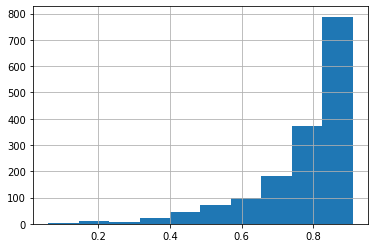

In [299]:
spotify_artists_no_duplicate_df.loc[spotify_artists_no_duplicate_df['spotify_similarity'] < 0.92]['spotify_similarity'].hist(bins=10)

In [327]:
spotify_artists_no_duplicate_df.loc[spotify_artists_no_duplicate_df['spotify_similarity'] >= 0].nunique()

artist_name           28563
spotify_name          28103
spotify_id            28106
spotify_similarity       80
spotify_popularity       99
spotify_followers     14881
spotify_listeners      5317
spotify_genre_1        2875
spotify_genre_2        2244
spotify_genre_3        1656
spotify_genre_4        1211
spotify_genre_5         848
spotify_genre_6         602
spotify_genre_7         429
spotify_genre_8         307
spotify_genre_9         211
spotify_genre_10        151
spotify_genre_11         99
spotify_genre_12         61
spotify_genre_13         36
spotify_genre_14         22
spotify_genre_15         16
spotify_genre_16          6
spotify_genre_17          4
spotify_genre_18          2
linked_artist_id      28106
dtype: int64

In [316]:
# create df of artists with worst spotify_similarity score for verification

low_similarity_df = spotify_artists_no_duplicate_df.loc[spotify_artists_no_duplicate_df['spotify_similarity'] < 0.7]
low_similarity_df = low_similarity_df.sort_values(by=['spotify_similarity'])
#low_similarity_df.to_csv('data/spotify/data_spotify_artists_check_low_similarity_2.csv', encoding='utf-8')
low_similarity_df

,artist_name,spotify_name,spotify_id,spotify_similarity,spotify_popularity,spotify_followers,spotify_listeners,spotify_genre_1,spotify_genre_2,spotify_genre_3,...,spotify_genre_10,spotify_genre_11,spotify_genre_12,spotify_genre_13,spotify_genre_14,spotify_genre_15,spotify_genre_16,spotify_genre_17,spotify_genre_18,linked_artist_id
artist_id,,,,,,,,,,,,,,,,,,,,,
/artists/3973706-giannes-kharoules,Γιάννης Χαρούλης,Giannis Haroulis,5cRPbjGpHYjeiBXfjNWOws,0.06,43.0,62341.0,68900.0,entehno,greek pop,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/3973706-giannes-kharoules
/artists/3033996-nochnyie-snaipiery,Ночные Снайперы,Diana Arbenina,3agWPIiWtN5ARZj1iMz5gk,0.07,45.0,137715.0,28900.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/3033996-nochnyie-snaipiery
/artists/10164684-eric-flores-aa,ÉRIC Flores AA,"Joe Rotondi, Danilo Lozano, Arturo Velasco, Da...",2k10r80WdyttmKfjW8fh2I,0.15,0.0,0.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/10164684-eric-flores-aa
/artists/8659244-jeff-lynnes-elo,Jeff Lynne's ELO,Electric Light Orchestra,7jefIIksOi1EazgRTfW2Pk,0.15,75.0,2984849.0,10500000.0,album rock,art rock,beatlesque,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/8659244-jeff-lynnes-elo
/artists/8022443-colin-morton-group,Colin Morton Group,"Choir of King's College, Cambridge",0f3PsS9IQ6whvNMFFKnpjl,0.19,57.0,57918.0,1000000.0,british choir,cambridge choir,choral,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/8022443-colin-morton-group
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/artists/777316-einar-stray,Einar Stray,Einar Stray Orchestra,3KNKt7f2QCeOhOraT5xdrc,0.69,11.0,3770.0,1800.0,oslo indie,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/777316-einar-stray
/artists/5052973-harbour-heads,The Harbour Heads,Kristoffer And The Harbour Heads,6SiVNy78yyHks1trqmvYTD,0.69,1.0,581.0,94.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/5052973-harbour-heads
/artists/9048559-nels-cline-four,The Nels Cline Four,Nels Cline,3s6o8vxtYJ1utkWl8EXxUp,0.69,34.0,19238.0,51200.0,avant-garde jazz,contemporary jazz,experimental guitar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/53910-nels-cline-singers


In [323]:
with open('data/spotify/data_spotify_artists_check_low_similarity.csv', encoding='utf-8') as file:
    check_similarity_df = pd.read_csv(file, index_col=0)
    
with open('data/spotify/data_spotify_artists_check_sample.csv', encoding='utf-8') as file:
    check_sample_df = pd.read_csv(file, index_col=0)

In [324]:
# get stats about manual verification

nbr_error_similarity = check_similarity_df['match_error'].count()
nbr_low_similarity = len(check_similarity_df)
ratio_error_similarity = round(nbr_error_similarity / nbr_low_similarity, 2)

nbr_error_sample = check_sample_df['match_error'].count()
nbr_sample = len(check_sample_df)
ratio_error_sample = round(nbr_error_sample / nbr_sample, 2)

print('Nbr low similarity checked:', nbr_low_similarity)
print('Nbr error similarity:', nbr_error_similarity)
print('Ratio error in low similarity artists:', ratio_error_similarity)

print('Nbr sample checked:', nbr_sample)
print('Nbr error sample:', nbr_error_sample)
print('Ratio error in sample:', ratio_error_sample)

Nbr low similarity checked: 338
Nbr error similarity: 226
Ratio error in low similarity artists: 0.67
Nbr sample checked: 300
Nbr error sample: 5
Ratio error in sample: 0.02


### Change duplicate artist in spotify_tracks data

In [427]:
with open('data/spotify/data_spotify_tracks.csv', encoding='utf-8') as file:
    tracks_df = pd.read_csv(file)
    tracks_df = tracks_df.rename(columns={'Unnamed: 0': 'track_id'})
    
with open('data/spotify/data_spotify_artists_no_duplicate.csv', encoding='utf-8') as file:
    spotify_artists_df = pd.read_csv(file, index_col=0)
    
tracks_df

,track_id,track_name,spotify_name,spotify_id,artist_id,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2UjEyfnKzaY7qpBEeESJjv,Even When The Water's Cold,!!!,1mmehjf7eHA10uHMisZGJg,/artists/3684861-chk-chk-chk,49,0.709,0.831,2.0,-6.847,0.0,0.0391,0.10800,0.001280,0.1590,0.866,104.971,227067.0,4.0
1,7y8aVfDkqt6qirGNivvs0M,One Girl / One Boy,!!!,1mmehjf7eHA10uHMisZGJg,/artists/3684861-chk-chk-chk,46,0.702,0.851,10.0,-5.747,0.0,0.0407,0.00255,0.000059,0.3220,0.870,117.004,243627.0,4.0
2,2PAn8J9dbmSnR4fLjpgehC,Dancing Is The Best Revenge,!!!,1mmehjf7eHA10uHMisZGJg,/artists/3684861-chk-chk-chk,43,0.857,0.762,1.0,-6.327,1.0,0.0535,0.00339,0.310000,0.0643,0.804,120.010,281558.0,4.0
3,0BjOgTLP0kLC88XqMoyrv8,Slyd,!!!,1mmehjf7eHA10uHMisZGJg,/artists/3684861-chk-chk-chk,40,0.858,0.717,0.0,-8.734,1.0,0.0995,0.06260,0.243000,0.2160,0.582,120.004,254920.0,4.0
4,19plwOsYLdF68361d17aAb,Myth Takes,!!!,1mmehjf7eHA10uHMisZGJg,/artists/3684861-chk-chk-chk,36,0.754,0.770,11.0,-7.830,0.0,0.0272,0.13300,0.747000,0.2930,0.904,97.109,143987.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248620,2TU6JSgRLKgks1ydHdPQpC,Wheels in Motion,Heymoonshaker,1ar2o79WFRJbq4lci6jq55,/artists/5427898-heymoonshaker,18,0.810,0.378,2.0,-9.397,1.0,0.0596,0.52600,0.009470,0.0909,0.320,91.957,200844.0,4.0
248621,66lXofi3mf385buHSMiKZN,Find Myself a Home,Heymoonshaker,1ar2o79WFRJbq4lci6jq55,/artists/5427898-heymoonshaker,16,0.740,0.635,11.0,-9.484,0.0,0.0602,0.53800,0.001940,0.0818,0.114,120.498,236453.0,4.0
248622,5Fl64Ztk3D90gTQbdhZqj0,Devil in Mind,Heymoonshaker,1ar2o79WFRJbq4lci6jq55,/artists/5427898-heymoonshaker,13,0.703,0.595,1.0,-9.310,0.0,0.1190,0.00850,0.483000,0.1090,0.573,75.863,271440.0,4.0
248623,1JA12esXthNQiikiQDmbrv,Coz I Luv U,Heymoonshaker,1ar2o79WFRJbq4lci6jq55,/artists/5427898-heymoonshaker,13,0.746,0.706,2.0,-6.560,0.0,0.1140,0.51700,0.000005,0.1230,0.519,134.147,184477.0,4.0


In [441]:
# add linked_artist_id column
tracks_clean_df = tracks_df.merge(spotify_artists_df[['spotify_id', 'linked_artist_id']], how='left', on='spotify_id')
# remove duplicate rows (added because of duplicate spotify_id artists)
tracks_clean_df = tracks_clean_df.drop_duplicates(['track_id'], keep='first').sort_values(by=['spotify_id', 'track_id'])
# change the values of artist_id column to values of linked_artist_id
tracks_clean_df['artist_id'] = tracks_clean_df['linked_artist_id']
# remove column linked_artist_id
tracks_clean_df = tracks_clean_df.drop(columns=['linked_artist_id'])
tracks_clean_df = tracks_clean_df.set_index('track_id')

tracks_clean_df

,track_name,spotify_name,spotify_id,artist_id,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
track_id,,,,,,,,,,,,,,,,,,
20a7nkw3Mj8C2iVQBgz10X,Cells,Motion Drive,0001wHqxbF2YYRQxGdbyER,/artists/1179216-motion-drive,8,0.608,0.728,8.0,-6.014,1.0,0.0365,0.000345,0.865,0.0741,0.153,131.992,480000.0,4.0
2jXv1eQoORVq2jPITROvMQ,Dualdrive,Motion Drive,0001wHqxbF2YYRQxGdbyER,/artists/1179216-motion-drive,22,0.763,0.855,7.0,-6.025,1.0,0.0388,0.000922,0.815,0.3370,0.524,132.018,496280.0,4.0
37XyXRMsEHwA7Fz9020VF6,Puppetmaster,Motion Drive,0001wHqxbF2YYRQxGdbyER,/artists/1179216-motion-drive,7,0.635,0.742,7.0,-7.738,1.0,0.0391,0.005000,0.830,0.2870,0.278,132.999,569642.0,4.0
3n4Gc2ES7UwvbJ3lh5QVnV,Thrilled Version 2,Motion Drive,0001wHqxbF2YYRQxGdbyER,/artists/1179216-motion-drive,2,0.598,0.845,7.0,-7.926,1.0,0.0433,0.001190,0.797,0.5670,0.410,131.985,476320.0,4.0
5nn11m2aCK3jbqh0xQKQd2,Jessica Lee - Motion Drive Remix,Motion Drive,0001wHqxbF2YYRQxGdbyER,/artists/1179216-motion-drive,8,0.607,0.770,7.0,-10.538,1.0,0.0547,0.009180,0.818,0.1520,0.106,133.013,546505.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5YJkBqBKcHBpIUDsar0RCE,Bahamas - Daniel Meister Remix,Daniel Meister,7zyqPpoCgfy4KZaqnMY70O,/artists/5389813-daniel-meister,11,0.812,0.827,1.0,-10.803,1.0,0.0689,0.000755,0.885,0.0586,0.803,122.016,410000.0,4.0
69aGh9vBSKKWlpki8z0jl2,Mo,Daniel Meister,7zyqPpoCgfy4KZaqnMY70O,/artists/5389813-daniel-meister,7,0.798,0.853,11.0,-11.975,0.0,0.0784,0.007760,0.937,0.0898,0.450,129.014,239070.0,4.0
6LojCeyuhDloizAjPdWRLx,Our Space - Daniel Meister Remix,Daniel Meister,7zyqPpoCgfy4KZaqnMY70O,/artists/5389813-daniel-meister,8,0.810,0.852,2.0,-9.007,1.0,0.0603,0.000095,0.951,0.0490,0.669,127.993,363438.0,4.0


In [442]:
tracks_clean_df.to_csv('data/spotify/data_spotify_tracks_no_duplicate.csv', encoding='utf-8')

## Clean data files
---

In [199]:
with open('data/songkick/data_songkick_venues_no_duplicate.csv', encoding='utf-8') as file:
    venues_no_duplicate_df = pd.read_csv(file, index_col=0)
    
with open('data/spotify/data_spotify_artists_no_duplicate.csv', encoding='utf-8') as file:
    artists_no_duplicates_df = pd.read_csv(file, index_col=0)
    
artists_no_duplicates_df

,artist_name,spotify_name,spotify_id,spotify_similarity,spotify_popularity,spotify_followers,spotify_listeners,spotify_genre_1,spotify_genre_2,spotify_genre_3,...,spotify_genre_10,spotify_genre_11,spotify_genre_12,spotify_genre_13,spotify_genre_14,spotify_genre_15,spotify_genre_16,spotify_genre_17,spotify_genre_18,linked_artist_id
artist_id,,,,,,,,,,,,,,,,,,,,,
/artists/3684861-chk-chk-chk,!!! (Chk Chk Chk),!!!,1mmehjf7eHA10uHMisZGJg,0.30,47.0,135100.0,305800.0,alternative dance,dance rock,dance-punk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/3684861-chk-chk-chk
/artists/694091-kadebostan,!!!Kadebostan!!!,Kadebostan,6hWRK8VkzbYP9p17M5APJR,0.77,11.0,1348.0,2000.0,swiss techno,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/694091-kadebostan
/artists/5929284-brothers-in-bamako,"""Brothers In Bamako""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/5929284-brothers-in-bamako
/artists/8704378-floyd-division-the-austrian-pink-floyd-tribute-band,"""Floyd Division"" The Austrian Pink Floyd Tribu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/8704378-floyd-division-the-austrian-p...
/artists/7172094-jazzetcetera-stewy-von-wattenwyl-group-feat-lisette-spinnler,"""Jazz...etcetera"" Stewy von Wattenwyl Group, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/7172094-jazzetcetera-stewy-von-watten...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/artists/4301-and-you-will-know-us-by-the-trail-of-dead,…And You Will Know Us by the Trail of Dead,...And You Will Know Us by the Trail of Dead,6wBUn8gMP85n8dPu6LoUcF,0.95,41.0,64802.0,99200.0,alternative rock,double drumming,indie rock,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/4301-and-you-will-know-us-by-the-trai...
/artists/1099500-euuroshima,€urOshima,Taro Urashima,5RSxs4Rb82wINvjv5KJ7JK,0.64,36.0,14600.0,79300.0,okinawan pop,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/1099500-euuroshima
/artists/9573874-belize-it,≈ Belize ≈,≈ Belize ≈,3b8bBMsmGoBd8gYn1pngNc,1.00,18.0,6697.0,4900.0,italian indie pop,milan indie,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/artists/9573874-belize-it


### Create light data files

In [200]:
# concerts light df

min_date = datetime.date(2010, 1, 1)
max_date = datetime.date(2020, 1, 1)

# keep only 3 columns
concerts_light_df = concerts_df[['type', 'venue_id', 'startDate']]
# set index as a column (concert_id)
concerts_light_df = concerts_light_df.reset_index()
# rename index and startDate columns
concerts_light_df = concerts_light_df.rename(columns={'index': 'concert_id', 'startDate': 'date'})
# sort by date
concerts_light_df = concerts_light_df.sort_values(by=['date'])
# keep only concerts between 2010 and 2019 (included)
concerts_light_df = concerts_light_df[
    (concerts_light_df['date'] >= str(min_date)) & 
    (concerts_light_df['date'] < str(max_date))
]
concerts_light_df = concerts_light_df.reset_index(drop=True)
concerts_light_df.to_csv('data/songkick/data_songkick_concerts_light.csv', encoding='utf-8')
concerts_light_df

,concert_id,type,venue_id,date
0,/concerts/7121486,concert,/venues/357736,2010-01-01
1,/concerts/3020551,concert,/venues/514666,2010-01-04
2,/concerts/3162911,concert,/venues/616116,2010-01-06
3,/concerts/5321916,concert,/venues/86235,2010-01-07
4,/concerts/10121483,concert,/venues/71759,2010-01-08
...,...,...,...,...
67771,/concerts/39139915,concert,/venues/3870614,2019-12-31
67772,/concerts/39220802,concert,/venues/184783,2019-12-31
67773,/concerts/39164391,concert,/venues/37717,2019-12-31
67774,/concerts/39294054,concert,/venues/2743988,2019-12-31


In [201]:
# artists light df

artists_light_df = artists_no_duplicates_df[['linked_artist_id', 'artist_name', 'spotify_name', 'spotify_id', 'spotify_followers', 'spotify_listeners']]
artists_light_df = artists_light_df.reset_index().rename(columns={'index': 'artist_id'})
artists_light_df.to_csv('data/spotify/data_spotify_artists_light.csv', encoding='utf-8')
artists_light_df

,artist_id,linked_artist_id,artist_name,spotify_name,spotify_id,spotify_followers,spotify_listeners
0,/artists/3684861-chk-chk-chk,/artists/3684861-chk-chk-chk,!!! (Chk Chk Chk),!!!,1mmehjf7eHA10uHMisZGJg,135100.0,305800.0
1,/artists/694091-kadebostan,/artists/694091-kadebostan,!!!Kadebostan!!!,Kadebostan,6hWRK8VkzbYP9p17M5APJR,1348.0,2000.0
2,/artists/5929284-brothers-in-bamako,/artists/5929284-brothers-in-bamako,"""Brothers In Bamako""",NaN,NaN,NaN,NaN
3,/artists/8704378-floyd-division-the-austrian-p...,/artists/8704378-floyd-division-the-austrian-p...,"""Floyd Division"" The Austrian Pink Floyd Tribu...",NaN,NaN,NaN,NaN
4,/artists/7172094-jazzetcetera-stewy-von-watten...,/artists/7172094-jazzetcetera-stewy-von-watten...,"""Jazz...etcetera"" Stewy von Wattenwyl Group, ...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
32226,/artists/4301-and-you-will-know-us-by-the-trai...,/artists/4301-and-you-will-know-us-by-the-trai...,…And You Will Know Us by the Trail of Dead,...And You Will Know Us by the Trail of Dead,6wBUn8gMP85n8dPu6LoUcF,64802.0,99200.0
32227,/artists/1099500-euuroshima,/artists/1099500-euuroshima,€urOshima,Taro Urashima,5RSxs4Rb82wINvjv5KJ7JK,14600.0,79300.0
32228,/artists/9573874-belize-it,/artists/9573874-belize-it,≈ Belize ≈,≈ Belize ≈,3b8bBMsmGoBd8gYn1pngNc,6697.0,4900.0
32229,/artists/8889739-luo-chai-cao-yuan-wwww-prairi...,/artists/8889739-luo-chai-cao-yuan-wwww-prairi...,落差草原 WWWW / Prairie WWWW,NaN,NaN,NaN,NaN


In [202]:
# venues light df

venues_light_df = venues_no_duplicate_df[['linked_venue_id', 'venue', 'locality', 'latitude', 'longitude']]
venues_light_df = venues_light_df.sort_values(by='venue')
venues_light_df = venues_light_df.reset_index().rename(columns={'index': 'venue_id'})
venues_light_df.to_csv('data/songkick/data_songkick_venues_light.csv', encoding='utf-8')
venues_light_df

,venue_id,linked_venue_id,venue,locality,latitude,longitude
0,/venues/2351864,/venues/2351864,"""Moon and Stars"" Open Air",Locarno,NaN,NaN
1,/venues/1265176,/venues/1265176,'mischkult-kultur Am Mischpult' on Rabe Radio ...,Bern,NaN,NaN
2,/venues/2311809,/venues/2311809,1 to 1 Energy Happening,Lyss,NaN,NaN
3,/venues/2938518,/venues/2938518,1. Mai-feier,Bern,46.75974,7.62869
4,/venues/613866,/venues/613866,1. Stock,Basel,NaN,NaN
...,...,...,...,...,...,...
7652,/venues/4389762,/venues/4389762,"Überseh-Bar, Villmergen b. Wohlen",Wohlen,47.34466,8.23688
7653,/venues/3316569,/venues/3316569,Üdiker-Huus,Zürich,47.30317,8.44879
7654,/venues/4358358,/venues/4358358,à la cArte,Langenthal,47.21192,7.78924
7655,/venues/4392674,/venues/4392674,à propos festival,Bern,NaN,NaN


### Merge data
---

In [203]:
# show all artists for each concert (one artist per row)

# get the column names where artists are stored
columns_list = ['artist_url_' + str(x) for x in range(1, 70)]
# create df with only artists columns (concert id as index)
artists_from_concerts_df = concerts_df[concerts_df.columns.intersection(columns_list)].fillna('')
# create dict of dict {concert_id_1: {'artist_id_1': artist_1, 'artist_id_2': artist_2, ...}, concert_id_2: {...}, ...}
artists_from_concerts_dict = artists_from_concerts_df.to_dict(orient='index')

concerts_list = list()
concerts_without_artist = set()
for concert, artists in artists_from_concerts_dict.items():
    artists_set = set(artists.values())
    artists_set.discard('')
    if artists_set:
        for artist in artists_set:
            concerts_list.append({'concert_id': concert, 'artist_id': artist})
    else:
        concerts_without_artist.add(concert)
        
concerts_artists_df = pd.DataFrame(concerts_list)
# only keep concerts between 2010 and 2020
concerts_artists_df = concerts_artists_df.merge(concerts_light_df['concert_id'], left_on='concert_id', right_on='concert_id')

print('Nbr concerts without an artist:', len(concerts_without_artist))  # concerts without artist are exclusively festivals with no line-up data on songkick
concerts_artists_df

Nbr concerts without an artist: 578


,concert_id,artist_id
0,/festivals/3267425,/artists/10069604-flavio-stonex
1,/festivals/3250138,/artists/10069604-flavio-stonex
2,/concerts/32335899,/artists/11032-jazz-connection
3,/concerts/32335884,/artists/11032-jazz-connection
4,/concerts/13429724,/artists/2865626-james-lann
...,...,...
97615,/concerts/14836234,/artists/456971-funeral-for-a-friend
97616,/concerts/14836234,/artists/424864-silverstein
97617,/concerts/14836234,/artists/4578008-tidal-sleep
97618,/concerts/16089124,/artists/6316464-vatsgoed


In [204]:
# show all venues with all their concerts with all their artists

venues_concerts_artists_df = concerts_artists_df.merge(concerts_light_df, on='concert_id')
# add linked_venue_id column to data
venues_concerts_artists_df = venues_concerts_artists_df.merge(venues_light_df, on='venue_id')
# add linked_artist_id column to data
venues_concerts_artists_df = venues_concerts_artists_df.merge(artists_light_df[['artist_id', 'linked_artist_id']], on='artist_id')
# if multiple concerts by same artist happen on the same day, keep only one
venues_concerts_artists_df = venues_concerts_artists_df.drop_duplicates(['linked_artist_id', 'date', 'latitude', 'longitude'], keep='first')
# drop original venue_id column, keep only linked_venue_id, concert_id and artist_id
venues_concerts_artists_df = venues_concerts_artists_df[['linked_venue_id', 'concert_id', 'linked_artist_id']]
# rename linked_venue_id column to venue_id
venues_concerts_artists_df = venues_concerts_artists_df.rename(columns={'linked_venue_id': 'venue_id'})
# rename linked_artist_id column to artist_id
venues_concerts_artists_df = venues_concerts_artists_df.rename(columns={'linked_artist_id': 'artist_id'})
# reset index (since some rows were dropped)
venues_concerts_artists_df = venues_concerts_artists_df.reset_index(drop=True)

venues_concerts_artists_df.to_csv('data/data_venues_concerts_artists.csv', encoding='utf-8')
venues_concerts_artists_df

,venue_id,concert_id,artist_id
0,/venues/1943879,/festivals/3267425,/artists/10069604-flavio-stonex
1,/venues/1943879,/festivals/3250138,/artists/10069604-flavio-stonex
2,/venues/4353777,/festivals/3262463,/artists/10069604-flavio-stonex
3,/venues/4353777,/festivals/3243521,/artists/10069604-flavio-stonex
4,/venues/4353777,/festivals/3252459,/artists/10069604-flavio-stonex
...,...,...,...
96273,/venues/1129971,/concerts/15880104,/artists/6538434-twinsmatic
96274,/venues/1129971,/concerts/15328664,/artists/2699691-we-are-the-in-crowd
96275,/venues/1129971,/concerts/15328664,/artists/2338458-never-shout-never
96276,/venues/1129971,/concerts/15048354,/artists/295364-propagandhi


In [205]:
# show all genres for each artist

# get the column names where genres are stored
columns_list = ['spotify_genre_' + str(x) for x in range(1, 20)]
columns_list.append('linked_artist_id')
# create df with only genres columns (artist id as index)
genres_of_artists_df = artists_no_duplicates_df[artists_no_duplicates_df.columns.intersection(columns_list)].fillna('')
# remove artist duplicates
genres_of_artists_df = genres_of_artists_df.drop_duplicates(['linked_artist_id'], keep='first')
# set linked_artist_id as the index
genres_of_artists_df = genres_of_artists_df.set_index('linked_artist_id')

# create dict of dict {artist_id_1: {'spotify_genre_1': genre_1, 'spotify_genre_2': genre_2, ...}, artist_id_2: {...}, ...}
genres_of_artists_dict = genres_of_artists_df.to_dict(orient='index')

artists_list = list()
for artist, genres in genres_of_artists_dict.items():
    genres_set = set(genres.values())
    genres_set.discard('')
    # if there is at least one genre linked to artist
    if genres_set:
        for genre in genres_set:
            artists_list.append({'artist_id': artist, 'spotify_genre': genre})
    else:
        artists_list.append({'artist_id': artist})

artists_genres_df = pd.DataFrame(artists_list)
artists_genres_df

,artist_id,spotify_genre
0,/artists/3684861-chk-chk-chk,dance rock
1,/artists/3684861-chk-chk-chk,electronica
2,/artists/3684861-chk-chk-chk,new rave
3,/artists/3684861-chk-chk-chk,sacramento indie
4,/artists/3684861-chk-chk-chk,alternative dance
...,...,...
63190,/artists/1099500-euuroshima,okinawan pop
63191,/artists/9573874-belize-it,italian indie pop
63192,/artists/9573874-belize-it,milan indie
63193,/artists/8889739-luo-chai-cao-yuan-wwww-prairi...,NaN


In [206]:
# show all artists with each of their top genre

artists_top_genres_df =  artists_genres_df.merge(genres_df, how='left', on='spotify_genre')

#for idx, row in artists_top_genres_df.iterrows():
#    if pd.notna(row['spotify_genre']) and not pd.notna(row['top_genre']):
#        print(idx)
    
artists_top_genres_df

,artist_id,spotify_genre,top_genre
0,/artists/3684861-chk-chk-chk,dance rock,dance music
1,/artists/3684861-chk-chk-chk,dance rock,rock music
2,/artists/3684861-chk-chk-chk,electronica,electronic music
3,/artists/3684861-chk-chk-chk,new rave,independent music
4,/artists/3684861-chk-chk-chk,new rave,rock music
...,...,...,...
94595,/artists/9573874-belize-it,italian indie pop,pop music
94596,/artists/9573874-belize-it,italian indie pop,rock music
94597,/artists/9573874-belize-it,milan indie,rock music
94598,/artists/8889739-luo-chai-cao-yuan-wwww-prairi...,NaN,NaN


In [207]:
# show all venues, with all their concerts, with all their artists and their top genres

full_data_df = venues_concerts_artists_df.merge(artists_top_genres_df, how='right', on='artist_id')
# drop rows where artists are not linked to a concert (because no concert between 2010-2020)
full_data_df = full_data_df.dropna(subset=['concert_id'])
# drop rows where artists don't have a spotify match
full_data_df = full_data_df.merge(artists_df['spotify_id'], left_on='artist_id', right_index=True)
full_data_df = full_data_df.dropna(subset=['spotify_id']).drop(columns=['spotify_id'])

full_data_df.to_csv('data/full_data.csv', encoding='utf-8')
full_data_df.iloc[:]

,venue_id,concert_id,artist_id,spotify_genre,top_genre
0,/venues/1943879,/festivals/3267425,/artists/10069604-flavio-stonex,NaN,NaN
1,/venues/1943879,/festivals/3250138,/artists/10069604-flavio-stonex,NaN,NaN
2,/venues/4353777,/festivals/3262463,/artists/10069604-flavio-stonex,NaN,NaN
3,/venues/4353777,/festivals/3243521,/artists/10069604-flavio-stonex,NaN,NaN
4,/venues/4353777,/festivals/3252459,/artists/10069604-flavio-stonex,NaN,NaN
...,...,...,...,...,...
319125,/venues/1129971,/concerts/14836239,/artists/591687-abandon-all-ships,trancecore,dance music
319126,/venues/1129971,/concerts/14836239,/artists/591687-abandon-all-ships,canadian post-hardcore,experimental music
319127,/venues/1129971,/concerts/14836239,/artists/591687-abandon-all-ships,canadian post-hardcore,rock music
319128,/venues/1129971,/concerts/14836239,/artists/591687-abandon-all-ships,canadian post-hardcore,dance music


In [33]:
artist_columns = ['artist_id', 'artist_name', 'spotify_name', 'spotify_id', 'spotify_followers', 'spotify_listeners']
venue_columns = ['venue_id', 'venue', 'locality', 'latitude', 'longitude']
concert_columns = ['concert_id', 'date']

full_data_df = full_data_df.merge(artists_light_df[artist_columns], on='artist_id')
full_data_df = full_data_df.merge(venues_light_df[venue_columns], on='venue_id')
full_data_df = full_data_df.merge(concerts_light_df[concert_columns], on='concert_id')
full_data_df.to_csv('data/full_data_large.csv', encoding='utf-8')
full_data_df

,venue_id,concert_id,artist_id,spotify_genre,top_genre,artist_name_x,spotify_name_x,spotify_id_x,spotify_followers_x,spotify_listeners_x,...,artist_name_y,spotify_name_y,spotify_id_y,spotify_followers_y,spotify_listeners_y,venue_y,locality_y,latitude_y,longitude_y,date_y
0,/venues/1943879,/festivals/3267425,/artists/10069604-flavio-stonex,NaN,NaN,Flavio Stonex,Flavio Stonex,7pvKRLZVc6sw0bgF2RBcGw,273.0,298.0,...,Flavio Stonex,Flavio Stonex,7pvKRLZVc6sw0bgF2RBcGw,273.0,298.0,"Sargans, Switzerland",Mels,47.04380,9.42400,2019-11-22
1,/venues/1943879,/festivals/3250138,/artists/10069604-flavio-stonex,NaN,NaN,Flavio Stonex,Flavio Stonex,7pvKRLZVc6sw0bgF2RBcGw,273.0,298.0,...,Flavio Stonex,Flavio Stonex,7pvKRLZVc6sw0bgF2RBcGw,273.0,298.0,"Sargans, Switzerland",Mels,47.04380,9.42400,2019-10-12
2,/venues/1943879,/concerts/32335899,/artists/11032-jazz-connection,NaN,NaN,Jazz Connection,Jazz Connection,6mP02lJJs2CloTXhohwVW5,287.0,3300.0,...,Jazz Connection,Jazz Connection,6mP02lJJs2CloTXhohwVW5,287.0,3300.0,"Sargans, Switzerland",Mels,47.04380,9.42400,2018-08-11
3,/venues/1943879,/concerts/32335884,/artists/11032-jazz-connection,NaN,NaN,Jazz Connection,Jazz Connection,6mP02lJJs2CloTXhohwVW5,287.0,3300.0,...,Jazz Connection,Jazz Connection,6mP02lJJs2CloTXhohwVW5,287.0,3300.0,"Sargans, Switzerland",Mels,47.04380,9.42400,2018-08-10
4,/venues/1943879,/concerts/13429724,/artists/2865626-james-lann,texas country,world music,James Lann,James Lann,4sCVOXpeqwAvbsjm2hVJTe,2832.0,2800.0,...,James Lann,James Lann,4sCVOXpeqwAvbsjm2hVJTe,2832.0,2800.0,"Sargans, Switzerland",Mels,47.04380,9.42400,2012-08-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317181,/venues/2848088,/concerts/22485123,/artists/8340968-oblium,NaN,NaN,Oblium,Oblium,4GtHfRKgPMKQ2JfTJfgUBK,242.0,172.0,...,Oblium,Oblium,4GtHfRKgPMKQ2JfTJfgUBK,242.0,172.0,1200MICROMETERS OUTDOOR RITUAL - Labyrinthine ...,Lugano,46.00651,8.95231,2014-12-31
317182,/venues/3085534,/concerts/24772624,/artists/161929-thibaud-couturier,NaN,NaN,Thibaud Couturier,Thibaud Couturier,6lM9qzr3MH9P3pd4rDnRpz,15.0,6.0,...,Thibaud Couturier,Thibaud Couturier,6lM9qzr3MH9P3pd4rDnRpz,15.0,6.0,Salle Des Fêtes De Saint Martin,Martigny,46.76691,6.75594,2015-11-14
317183,/venues/3822394,/concerts/33069884,/artists/9420539-mj30,rumba congolaise,world music,MJ30,MJ30,47LyTgOlJEHVtxhlrwYHqp,2676.0,537.0,...,MJ30,MJ30,47LyTgOlJEHVtxhlrwYHqp,2676.0,537.0,Soirée à l'honneur des femmes,Geneva,46.20327,6.13489,2018-03-17
317184,/venues/2626963,/concerts/20445908,/artists/886867-phil-donkin,NaN,NaN,Phil Donkin,Phil Donkin,2GddInGkfbHJTjjlCxX7P5,130.0,1300.0,...,Phil Donkin,Phil Donkin,2GddInGkfbHJTjjlCxX7P5,130.0,1300.0,"Theater Gleis 5, Forum Für Andere Musik",Winterthur,47.55730,8.89941,2014-05-09


## Stats
---

'2010-01-01'

### Genres in venues stats
---

In [41]:
with open('data/full_data.csv', encoding='utf-8') as file:
    full_data_df = pd.read_csv(file).drop(columns=['Unnamed: 0'])
    
with open('data/songkick/data_songkick_venues_light.csv', encoding='utf-8') as file:
    venues_df = pd.read_csv(file, index_col=0)

venues_df

,venue_id,linked_venue_id,venue,locality,latitude,longitude
0,/venues/2351864,/venues/2351864,"""Moon and Stars"" Open Air",Locarno,NaN,NaN
1,/venues/1265176,/venues/1265176,'mischkult-kultur Am Mischpult' on Rabe Radio ...,Bern,NaN,NaN
2,/venues/2311809,/venues/2311809,1 to 1 Energy Happening,Lyss,NaN,NaN
3,/venues/2938518,/venues/2938518,1. Mai-feier,Bern,46.75974,7.62869
4,/venues/613866,/venues/613866,1. Stock,Basel,NaN,NaN
...,...,...,...,...,...,...
7652,/venues/4389762,/venues/4389762,"Überseh-Bar, Villmergen b. Wohlen",Wohlen,47.34466,8.23688
7653,/venues/3316569,/venues/3316569,Üdiker-Huus,Zürich,47.30317,8.44879
7654,/venues/4358358,/venues/4358358,à la cArte,Langenthal,47.21192,7.78924
7655,/venues/4392674,/venues/4392674,à propos festival,Bern,NaN,NaN


In [5]:
print('Nbr concerts:', len(full_data_df['concert_id'].unique()))
print('Nbr venues:', len(full_data_df['venue_id'].unique()))
print('Nbr artists:', len(full_data_df['artist_id'].unique()))
print('Nbr genres:', len(full_data_df['spotify_genre'].unique()))
print('Nbr top genres:', len(full_data_df['top_genre'].unique()))

Nbr concerts: 63708
Nbr venues: 5094
Nbr artists: 25098
Nbr genres: 3650
Nbr top genres: 24


In [6]:
# get number of concerts and artists in each venue and store it in a dict

venues_nbr_concerts = full_data_df.groupby('venue_id')['concert_id'].nunique()
venues_nbr_concerts.name = 'nbr_concerts'
venues_nbr_concerts_dict = pd.DataFrame(venues_nbr_concerts).to_dict(orient='index')

venues_nbr_artists = full_data_df.groupby('venue_id')['artist_id'].nunique()
venues_nbr_artists.name = 'nbr_artists'
venues_nbr_artists_dict = pd.DataFrame(venues_nbr_artists).to_dict(orient='index')

for venue in venues_nbr_concerts_dict.keys():
    nbr_artists = venues_nbr_artists_dict[venue]
    venues_nbr_concerts_dict[venue].update(nbr_artists)
    
venues_nbr_concerts_dict

{'/venues/1002631': {'nbr_concerts': 2, 'nbr_artists': 1},
 '/venues/1004201': {'nbr_concerts': 40, 'nbr_artists': 54},
 '/venues/1004876': {'nbr_concerts': 34, 'nbr_artists': 19},
 '/venues/1004881': {'nbr_concerts': 1, 'nbr_artists': 1},
 '/venues/1004891': {'nbr_concerts': 1, 'nbr_artists': 1},
 '/venues/1006731': {'nbr_concerts': 1, 'nbr_artists': 1},
 '/venues/100720': {'nbr_concerts': 3, 'nbr_artists': 5},
 '/venues/100790': {'nbr_concerts': 9, 'nbr_artists': 18},
 '/venues/1008231': {'nbr_concerts': 1, 'nbr_artists': 1},
 '/venues/1008911': {'nbr_concerts': 1, 'nbr_artists': 1},
 '/venues/1011066': {'nbr_concerts': 1, 'nbr_artists': 2},
 '/venues/101173': {'nbr_concerts': 457, 'nbr_artists': 555},
 '/venues/101332': {'nbr_concerts': 40, 'nbr_artists': 57},
 '/venues/101376': {'nbr_concerts': 1, 'nbr_artists': 1},
 '/venues/1014316': {'nbr_concerts': 7, 'nbr_artists': 7},
 '/venues/101668': {'nbr_concerts': 1, 'nbr_artists': 1},
 '/venues/1016706': {'nbr_concerts': 22, 'nbr_artis

In [79]:
# for each venue, get the number of concerts of every genre

stats_venues_genres_dict = venues_nbr_concerts_dict.copy()
for venue_id, stats in tqdm(venues_nbr_concerts_dict.items()):
    genres_dict = dict(full_data_df.loc[full_data_df['venue_id'] == venue_id].groupby('top_genre')['concert_id'].nunique())
    stats_venues_genres_dict[venue_id].update(genres_dict)
    
len(stats_venues_genres_dict)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5094/5094 [02:31<00:00, 33.66it/s]


5094

In [80]:
stats_venues_genres_df = pd.DataFrame.from_dict(stats_venues_genres_dict, orient='index')
stats_venues_genres_df = stats_venues_genres_df.fillna(0)
stats_venues_genres_df = stats_venues_genres_df.astype('int32')
stats_venues_genres_df

,nbr_concerts,nbr_artists,art music,dance music,hip hop music,pop music,rhythm and blues,world music,acoustic music,blues,...,jazz,rock music,vocal music,experimental music,funk,instrumental music,lo-fi music,soul music,underground music,children's music
/venues/1002631,2,1,2,2,2,2,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
/venues/1004201,40,54,13,14,17,22,0,27,4,12,...,4,22,3,0,0,0,0,0,0,0
/venues/1004876,34,19,0,0,3,2,0,6,0,0,...,2,5,0,0,0,0,0,0,0,0
/venues/1004881,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/venues/1004891,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/venues/988536,2,3,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
/venues/993251,5,5,0,0,0,1,1,5,0,1,...,1,0,0,0,1,0,0,0,0,0
/venues/996001,2,2,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
/venues/996021,1,1,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [81]:
stats_venues_genres_df.iloc[:,2:] = stats_venues_genres_df.iloc[:,2:].div(stats_venues_genres_df['nbr_concerts'], axis=0).round(2)
stats_venues_genres_df

,nbr_concerts,nbr_artists,art music,dance music,hip hop music,pop music,rhythm and blues,world music,acoustic music,blues,...,jazz,rock music,vocal music,experimental music,funk,instrumental music,lo-fi music,soul music,underground music,children's music
/venues/1002631,2,1,1.00,1.00,1.00,1.00,1.0,1.00,0.0,0.0,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/venues/1004201,40,54,0.32,0.35,0.42,0.55,0.0,0.68,0.1,0.3,...,0.10,0.55,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/venues/1004876,34,19,0.00,0.00,0.09,0.06,0.0,0.18,0.0,0.0,...,0.06,0.15,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/venues/1004881,1,1,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/venues/1004891,1,1,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/venues/988536,2,3,0.00,0.00,0.50,0.00,0.0,0.50,0.0,0.0,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/venues/993251,5,5,0.00,0.00,0.00,0.20,0.2,1.00,0.0,0.2,...,0.20,0.00,0.00,0.0,0.2,0.0,0.0,0.0,0.0,0.0
/venues/996001,2,2,0.00,0.50,0.00,0.00,0.0,0.00,0.0,0.0,...,0.50,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/venues/996021,1,1,0.00,0.00,1.00,0.00,0.0,1.00,0.0,0.0,...,1.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
# sort columns alphabetically
stats_venues_genres_df = stats_venues_genres_df.reindex(sorted(stats_venues_genres_df.columns), axis=1)

# put nbr_concerts col at 1st position
col1 = stats_venues_genres_df.pop('nbr_concerts')
col2 = stats_venues_genres_df.pop('nbr_artists')
stats_venues_genres_df.insert(0, col1.name, col1)
stats_venues_genres_df.insert(1, col2.name, col2)
stats_venues_genres_df

,nbr_concerts,nbr_artists,acoustic music,art music,blues,children's music,country music,dance music,electronic music,experimental music,...,instrumental music,jazz,lo-fi music,pop music,rhythm and blues,rock music,soul music,underground music,vocal music,world music
/venues/1002631,2,1,0.0,1.00,0.0,0.0,0.0,1.00,0.00,0.0,...,0.0,0.00,0.0,1.00,1.0,0.00,0.0,0.0,0.00,1.00
/venues/1004201,40,54,0.1,0.32,0.3,0.0,0.3,0.35,0.42,0.0,...,0.0,0.10,0.0,0.55,0.0,0.55,0.0,0.0,0.08,0.68
/venues/1004876,34,19,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.06,0.0,0.06,0.0,0.15,0.0,0.0,0.00,0.18
/venues/1004881,1,1,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
/venues/1004891,1,1,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/venues/988536,2,3,0.0,0.00,0.0,0.0,0.0,0.00,0.50,0.0,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.50
/venues/993251,5,5,0.0,0.00,0.2,0.0,0.0,0.00,0.00,0.0,...,0.0,0.20,0.0,0.20,0.2,0.00,0.0,0.0,0.00,1.00
/venues/996001,2,2,0.0,0.00,0.0,0.0,0.0,0.50,0.50,0.0,...,0.0,0.50,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
/venues/996021,1,1,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,1.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,1.00


In [90]:
# features left out: track_popularity, key, mode, type, time_signature
features_columns = [
    'artist_id', 'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'loudness', 'tempo', 'duration_ms',
]

# get median of audio features for each artist
tracks_median_df = tracks_df[features_columns].groupby('artist_id').median()
# add suffix median to column names
tracks_median_df = tracks_median_df.add_suffix('_median')
# sort columns alphabetically
tracks_median_df = tracks_median_df.reindex(sorted(tracks_median_df.columns), axis=1)

# drop rows where concert_id and artist_id are a duplicate (ex: duplicated rows bc of multiple top genres for an artist)
artists_in_concerts = full_data_df.drop_duplicates(subset=['concert_id', 'artist_id']).sort_values(by=['venue_id'])
# add artist listeners and followers stats, rename columns (remove spotify prefix)
artists_stats_df = artists_in_concerts.merge(
    artists_df[['spotify_listeners', 'spotify_followers']],
    left_on='artist_id', right_index=True)
artists_stats_df = artists_stats_df.rename(columns={'spotify_listeners': 'listeners', 'spotify_followers': 'followers'})
# add linked venue id
artists_stats_df = artists_stats_df.merge(venues_df['linked_venue_id'], left_on='venue_id', right_on='linked_venue_id')
# add artist audio features stats
artists_stats_df = artists_stats_df.merge(tracks_median_df, how='left', left_on='artist_id', right_index=True)

# get number of artists in each venue
stats_venues_features_df = pd.DataFrame(artists_stats_df.groupby('linked_venue_id')['artist_id'].nunique())
stats_venues_features_df = stats_venues_features_df.rename(columns={'artist_id': 'nbr_artists'})
# get median values of listeners and followers for each venue
stats_venues_features_df = stats_venues_features_df.join(pd.DataFrame(artists_stats_df.groupby('linked_venue_id').median()))
# rename columns with median value
stats_venues_features_df = stats_venues_features_df.rename(columns={
    'listeners': 'listeners_median',
    'followers': 'followers_median'})
# add venue name and locality to DataFrame
stats_venues_features_df = stats_venues_features_df.merge(
    venues_df[['venue_id']], left_index=True, right_on='venue_id')

stats_venues_features_df = stats_venues_features_df.set_index('venue_id')
stats_venues_features_df

,nbr_artists,listeners_median,followers_median,acousticness_median,danceability_median,duration_ms_median,energy_median,instrumentalness_median,liveness_median,loudness_median,speechiness_median,tempo_median,valence_median
venue_id,,,,,,,,,,,,,
/venues/1002631,1,7400000.0,6180634.0,0.039300,0.71600,206980.00,0.60650,0.000000,0.14950,-5.9085,0.07415,95.97600,0.34100
/venues/1004201,54,170100.0,20006.0,0.155500,0.67300,224113.50,0.62300,0.000118,0.12600,-8.1525,0.04600,119.99700,0.51650
/venues/1004876,19,1400.0,432.0,0.534500,0.66925,212600.00,0.43075,0.852000,0.11550,-11.1135,0.04055,113.14625,0.59425
/venues/1004881,1,636.0,1120.0,0.660500,0.56950,305440.50,0.26100,0.001261,0.10900,-14.6365,0.03510,117.98450,0.34200
/venues/1004891,1,4700.0,954.0,0.210050,0.43700,194373.50,0.45600,0.371000,0.13750,-10.3915,0.02975,113.97800,0.26450
...,...,...,...,...,...,...,...,...,...,...,...,...,...
/venues/988536,3,9600.0,566.0,0.026500,0.68700,197221.00,0.72850,0.431000,0.16600,-6.6340,0.07350,90.05200,0.57900
/venues/993251,5,199900.0,86803.0,0.427500,0.74700,285060.00,0.66800,0.000215,0.11350,-9.1985,0.05520,119.93500,0.73050
/venues/996001,2,86108.0,13503.5,0.435358,0.58875,335682.75,0.49825,0.823500,0.11335,-12.1585,0.04900,111.34125,0.29725


In [91]:
stats_venues_genres_df.to_csv('data/data_stats_venues_genres.csv', encoding='utf-8')
stats_venues_features_df.to_csv('data/data_stats_venues_features.csv', encoding='utf-8')

### Audio features stats
---

In [14]:
# features left out: track_popularity, key, mode, type, time_signature
features_columns = ['artist_id', 'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'loudness', 'tempo', 'duration_ms']

# get median of audio features for each artist
tracks_median_df = tracks_df[features_columns].groupby('artist_id').median()
# add suffix median to column names
tracks_median_df = tracks_median_df.add_suffix('_median')
# sort columns alphabetically
tracks_median_df = tracks_median_df.reindex(sorted(tracks_median_df.columns), axis=1)
tracks_median_df

,acousticness_median,danceability_median,duration_ms_median,energy_median,instrumentalness_median,liveness_median,loudness_median,speechiness_median,tempo_median,valence_median
artist_id,,,,,,,,,,
/artists/10000324-arthur-hnatek-trio,0.484000,0.5850,326667.0,0.3840,7.890000e-01,0.0928,-13.3650,0.08480,112.9270,0.2920
/artists/10000554-highland-sanctuary,0.506000,0.5790,194560.5,0.7125,4.675000e-05,0.1640,-7.9280,0.03595,95.0345,0.5355
/artists/10000674-carlos-elliot-jr,0.114000,0.7330,213907.0,0.6710,1.250000e-03,0.0775,-10.7820,0.03460,118.0970,0.9110
/artists/10000929-kit-sebastian,0.026850,0.5485,242924.0,0.7110,9.395000e-03,0.1085,-7.5840,0.03190,121.1880,0.4490
/artists/10001989-gallery-of-noise,0.204000,0.7520,301340.0,0.6660,8.750000e-01,0.1044,-12.7255,0.07065,123.5065,0.3220
...,...,...,...,...,...,...,...,...,...,...
/artists/9997994-helene-barbier,0.209000,0.6200,147856.5,0.3765,4.225000e-01,0.1400,-13.7130,0.03630,120.3010,0.7680
/artists/9999029-ricky-and-sam,0.056200,0.5475,232211.0,0.7475,0.000000e+00,0.1850,-4.8335,0.03110,133.4420,0.3475
/artists/99991-jlive,0.101500,0.7600,252740.0,0.7595,8.600000e-07,0.1245,-5.9730,0.29800,97.9835,0.7335


In [15]:
artists_in_concerts = full_data_df.drop_duplicates(subset=['concert_id', 'artist_id']).sort_values(by=['venue_id'])
artists_stats = artists_in_concerts.merge(artists_df[['spotify_listeners', 'spotify_followers']], left_on='artist_id', right_index=True)
artists_stats = artists_stats.merge(tracks_median_df, how='left', left_on='artist_id', right_index=True)
artists_stats

,concert_id,artist_id,spotify_genre,top_genre,spotify_id,venue_id,spotify_listeners,spotify_followers,acousticness_median,danceability_median,duration_ms_median,energy_median,instrumentalness_median,liveness_median,loudness_median,speechiness_median,tempo_median,valence_median
150836,/concerts/5400431,/artists/892651-samuel-blaser,swiss jazz,jazz,6tSNZs0irdfgzczCjYrw72,/venues/1001236,550.0,307.0,0.80400,0.4070,448317.5,0.2950,4.540000e-01,0.1130,-15.2125,0.06705,103.2490,0.222
150835,/concerts/6827586,/artists/892651-samuel-blaser,swiss jazz,jazz,6tSNZs0irdfgzczCjYrw72,/venues/1001236,550.0,307.0,0.80400,0.4070,448317.5,0.2950,4.540000e-01,0.1130,-15.2125,0.06705,103.2490,0.222
150834,/concerts/5400456,/artists/892651-samuel-blaser,swiss jazz,jazz,6tSNZs0irdfgzczCjYrw72,/venues/1001236,550.0,307.0,0.80400,0.4070,448317.5,0.2950,4.540000e-01,0.1130,-15.2125,0.06705,103.2490,0.222
150833,/concerts/5400956,/artists/892651-samuel-blaser,swiss jazz,jazz,6tSNZs0irdfgzczCjYrw72,/venues/1001236,550.0,307.0,0.80400,0.4070,448317.5,0.2950,4.540000e-01,0.1130,-15.2125,0.06705,103.2490,0.222
150838,/concerts/5400421,/artists/892651-samuel-blaser,swiss jazz,jazz,6tSNZs0irdfgzczCjYrw72,/venues/1001236,550.0,307.0,0.80400,0.4070,448317.5,0.2950,4.540000e-01,0.1130,-15.2125,0.06705,103.2490,0.222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389421,/concerts/2228046,/artists/468520-weyermann,NaN,NaN,2S0ICbhHpVbs9eL2ZzTOA4,/venues/99611,13.0,53.0,0.54250,0.6555,179676.0,0.6090,0.000000e+00,0.1215,-7.2105,0.10000,106.0230,0.349
389416,/concerts/2228046,/artists/5522478-frames-ie,irish rock,world music,6lyku6lhbB3tLc3Dghs5CM,/venues/99611,79600.0,70439.0,0.13355,0.4050,238513.5,0.3565,5.188500e-04,0.1175,-10.8610,0.03925,126.7295,0.257
389448,/concerts/2228046,/artists/429138-twang,britpop,pop music,19t4krGrwyr10giUMdv8BK,/venues/99611,89900.0,42573.0,0.09630,0.5695,221044.5,0.8855,6.150000e-07,0.1840,-3.8790,0.04300,116.0215,0.608
389453,/concerts/2228046,/artists/481321-wurzel5,mundart,world music,735iLNwRvdc39OXIbF9W4K,/venues/99611,28500.0,11571.0,0.08815,0.7285,246465.5,0.7075,0.000000e+00,0.2605,-5.9550,0.21800,92.0020,0.645


In [16]:
concerts_median_df = pd.DataFrame(concerts_stats.groupby('concert_id').size())
concerts_median_df = concerts_median_df.rename(columns={0: 'nbr_artists'})
concerts_median_df = concerts_median_df.join(pd.DataFrame(concerts_stats.groupby('concert_id').median()))
concerts_median_df = concerts_median_df.rename(columns={'spotify_listeners': 'listeners_median', 'spotify_followers': 'followers_median'})
concerts_median_df

NameError: name 'concerts_stats' is not defined

In [36]:
concerts_mean_median_df = concerts_mean_median_df.merge(concerts_df['venue_id'], left_index=True, right_index=True)
concerts_mean_median_df = concerts_mean_median_df.merge(venues_df['venue'], left_on='venue_id', right_index=True)
concerts_mean_median_df

,nbr_artists,listeners_median,followers_median,venue_id,venue
/concerts/10003028,2,48250.0,16428.0,/venues/1467723,Mouton Noir
/concerts/16229934,2,495.0,769.5,/venues/1467723,Mouton Noir
/concerts/18105114,1,50.0,64.0,/venues/1467723,Mouton Noir
/concerts/18463094,1,2200.0,1353.0,/venues/1467723,Mouton Noir
/concerts/18947534,1,338.0,653.0,/venues/1467723,Mouton Noir
...,...,...,...,...,...
/festivals/636444,2,1450235.0,99887.0,/venues/2182909,Espace Odyssée
/festivals/641694,9,13500.0,2982.0,/venues/3772934,Skigebiet Schönried-Saanenmöser
/festivals/653588,22,61950.0,32413.5,/venues/1350371,Moortal
/festivals/762629,3,106900.0,23843.0,/venues/3655339,Festival Tent


In [38]:
list(concerts_mean_median_df['venue_id'].unique())

['/venues/1467723',
 '/venues/613876',
 '/venues/93725',
 '/venues/58381',
 '/venues/121167',
 '/venues/514666',
 '/venues/114785',
 '/venues/130024',
 '/venues/30935',
 '/venues/180713',
 '/venues/32637',
 '/venues/78082',
 '/venues/58729',
 '/venues/1469868',
 '/venues/1409428',
 '/venues/388116',
 '/venues/843506',
 '/venues/121743',
 '/venues/33266',
 '/venues/1129971',
 '/venues/32250',
 '/venues/1161281',
 '/venues/50662',
 '/venues/33498',
 '/venues/2837343',
 '/venues/121833',
 '/venues/45690',
 '/venues/51503',
 '/venues/49813',
 '/venues/1471533',
 '/venues/391996',
 '/venues/33267',
 '/venues/31959',
 '/venues/618641',
 '/venues/814881',
 '/venues/2998139',
 '/venues/60548',
 '/venues/32891',
 '/venues/79392',
 '/venues/34315',
 '/venues/77146',
 '/venues/29644',
 '/venues/29550',
 '/venues/123515',
 '/venues/32834',
 '/venues/48460',
 '/venues/36157',
 '/venues/125906',
 '/venues/1475258',
 '/venues/583406',
 '/venues/419106',
 '/venues/1318116',
 '/venues/184783',
 '/venue

In [17]:
venues_mean_median_df = pd.DataFrame(concerts_stats.groupby('venue_id').size())
venues_mean_median_df = venues_mean_median_df.rename(columns={0: 'nbr_artists'})
venues_mean_median_df = venues_mean_median_df.join(pd.DataFrame(concerts_stats.groupby('venue_id').median()))
venues_mean_median_df = venues_mean_median_df.rename(columns={'spotify_listeners': 'listeners_median', 'spotify_followers': 'followers_median'})
venues_mean_median_df['nbr_artists']

venue_id
/venues/1001236     14
/venues/1004201    120
/venues/1004876     28
/venues/1006731      1
/venues/100720       7
                  ... 
/venues/986336       1
/venues/98757      172
/venues/988536       1
/venues/996021       1
/venues/99611       82
Name: nbr_artists, Length: 3099, dtype: int64

### Correlation matrix
---

In [19]:
full_stats_df = full_data_df.copy()
full_stats_df = full_stats_df.merge(artists_df[['spotify_listeners', 'spotify_followers']], left_on='artist_id', right_index=True)
full_stats_df = full_stats_df.merge(tracks_median_df, how='left', left_on='artist_id', right_index=True)
full_stats_df = full_stats_df.merge(venues_df[['latitude', 'longitude']], left_on='venue_id', right_index=True)
full_stats_df = full_stats_df.merge(concerts_df['startDate'], left_on='concert_id', right_index=True)

categorical_columns = ['concert_id', 'venue_id', 'artist_id', 'spotify_genre', 'top_genre']
categorical_labels = dict()

for column in categorical_columns:
    factorized_column = full_stats_df[column].factorize()
    full_stats_df[column] = factorized_column[0]
    categorical_labels[column] = factorized_column[1]

full_stats_df

,concert_id,artist_id,spotify_genre,top_genre,spotify_id,venue_id,spotify_listeners,spotify_followers,acousticness_median,danceability_median,...,energy_median,instrumentalness_median,liveness_median,loudness_median,speechiness_median,tempo_median,valence_median,latitude,longitude,startDate
0,0,0,-1,-1,7pvKRLZVc6sw0bgF2RBcGw,0,268.0,265.0,0.020700,0.6330,...,0.8340,0.078300,0.18600,-6.5920,0.04650,128.0170,0.15100,47.04380,9.42400,2021-08-14
31,0,1,-1,-1,1GTyV1KfeuVWyGMixYkI9P,0,868.0,716.0,0.075250,0.6455,...,0.7890,0.001255,0.21400,-8.8735,0.04320,123.0100,0.22645,47.04380,9.42400,2021-08-14
1,1,0,-1,-1,7pvKRLZVc6sw0bgF2RBcGw,0,268.0,265.0,0.020700,0.6330,...,0.8340,0.078300,0.18600,-6.5920,0.04650,128.0170,0.15100,47.04380,9.42400,2021-07-02
2,2,0,-1,-1,7pvKRLZVc6sw0bgF2RBcGw,0,268.0,265.0,0.020700,0.6330,...,0.8340,0.078300,0.18600,-6.5920,0.04650,128.0170,0.15100,47.04380,9.42400,2020-10-23
4,3,0,-1,-1,7pvKRLZVc6sw0bgF2RBcGw,0,268.0,265.0,0.020700,0.6330,...,0.8340,0.078300,0.18600,-6.5920,0.04650,128.0170,0.15100,47.04380,9.42400,2020-06-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397628,77358,28531,-1,-1,4GtHfRKgPMKQ2JfTJfgUBK,6450,221.0,223.0,0.001935,0.4165,...,0.8050,0.748000,0.36050,-11.1090,0.07690,178.9885,0.16150,46.00651,8.95231,2014-12-31
397629,77359,28532,-1,-1,6lM9qzr3MH9P3pd4rDnRpz,6451,1.0,15.0,0.311500,0.7305,...,0.5635,0.000003,0.10750,-9.3370,0.05500,119.0480,0.52250,46.76691,6.75594,2015-11-14
397630,77360,28533,3557,0,47LyTgOlJEHVtxhlrwYHqp,6452,531.0,2550.0,0.660000,0.7000,...,0.7770,0.000371,0.16250,-7.1375,0.06365,136.0060,0.80450,46.20327,6.13489,2018-03-17
397679,77361,28534,-1,-1,2GddInGkfbHJTjjlCxX7P5,6453,1300.0,127.0,0.641000,0.4670,...,0.4075,0.072650,0.08455,-10.9750,0.05120,126.9470,0.32650,47.55730,8.89941,2014-05-09


In [20]:
full_stats_df.corr().style.background_gradient()

,concert_id,artist_id,spotify_genre,top_genre,venue_id,spotify_listeners,spotify_followers,acousticness_median,danceability_median,duration_ms_median,energy_median,instrumentalness_median,liveness_median,loudness_median,speechiness_median,tempo_median,valence_median,latitude,longitude
concert_id,1.000000,0.436865,0.108135,0.001569,0.794298,-0.023985,-0.025792,0.086828,0.036605,0.054535,-0.104960,0.115220,-0.031522,-0.136987,-0.028033,-0.020280,-0.056864,-0.243243,-0.117054
artist_id,0.436865,1.000000,0.268205,0.008551,0.345696,0.034887,0.025628,0.057903,-0.008401,0.033987,-0.043302,0.080337,0.000151,-0.083496,-0.006329,0.002607,-0.027062,-0.162770,-0.099955
spotify_genre,0.108135,0.268205,1.000000,0.243648,0.100669,0.041168,0.025804,0.219127,-0.074600,0.046080,-0.190248,0.085404,-0.041725,-0.207446,-0.061636,-0.071369,-0.009181,-0.098152,-0.057600
top_genre,0.001569,0.008551,0.243648,1.000000,-0.014032,0.033593,0.004151,0.093184,-0.009629,0.123704,-0.100466,0.124651,-0.074549,-0.099615,-0.156064,0.002411,-0.073239,-0.017248,-0.017058
venue_id,0.794298,0.345696,0.100669,-0.014032,1.000000,-0.062024,-0.051308,0.158729,0.015414,0.056045,-0.170114,0.129009,-0.032502,-0.197095,-0.028721,-0.051078,-0.065641,-0.180038,-0.089935
spotify_listeners,-0.023985,0.034887,0.041168,0.033593,-0.062024,1.000000,0.829069,-0.048991,0.103977,-0.093609,0.029401,-0.151617,-0.045216,0.096989,-0.027375,-0.017672,0.085258,-0.007655,0.017463
spotify_followers,-0.025792,0.025628,0.025804,0.004151,-0.051308,0.829069,1.000000,-0.044227,0.046181,-0.044601,0.035494,-0.109252,-0.021385,0.079355,-0.010547,-0.010713,0.048364,0.011381,0.017171
acousticness_median,0.086828,0.057903,0.219127,0.093184,0.158729,-0.048991,-0.044227,1.000000,-0.111947,0.010878,-0.819159,0.102118,-0.174579,-0.703377,-0.126612,-0.314191,-0.143152,-0.080392,-0.008710
danceability_median,0.036605,-0.008401,-0.074600,-0.009629,0.015414,0.103977,0.046181,-0.111947,1.000000,-0.132332,-0.010660,-0.135232,-0.173718,0.127756,0.191750,-0.081685,0.504836,-0.016757,-0.001454
duration_ms_median,0.054535,0.033987,0.046080,0.123704,0.056045,-0.093609,-0.044601,0.010878,-0.132332,1.000000,-0.114027,0.532364,-0.094071,-0.279608,-0.138383,-0.024627,-0.345476,0.010447,-0.017648


In [116]:
artist_id = '/artists/3684861-chk-chk-chk'
artists_top_genres_df.loc[artists_top_genres_df['artist_id'] == artist_id]['top_genre'].unique()

array(['electronic music', 'dance music', 'rock music',
       'independent music'], dtype=object)